In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import time
import sys
import pickle

# Description
### This script is an excercise of **Metalabelling** (introduced by *Marcos M. Lopez de Prado*).

It utilizes the **Triple-barrier Labelling** to identify price trends and use **price features** to train a **trend prediction model** with **Random Forest** classifier.

# Data
Investment universe: <br>
`SPY` - Equity proxy <br>
`TLT` - Bond proxy <br>
`SVXY` - Volatility proxy (short) <br>
`GLD` - Gold proxy <br>

In [2]:
symbols = ['SPY','TLT','SVXY','GLD']
all_data = dict()
for symbol in symbols:
  # only close price is used for simplicity
  prc = yf.download(symbol).Close
  # convert to log price
  logprc = np.log(prc)
  all_data[symbol] = logprc

/Users/benkan45d6/opt/anaconda3/envs/py10/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Users/benkan45d6/opt/anaconda3/envs/py10/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Users/benkan45d6/opt/anaconda3/envs/py10/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.Timed

# Evaluation

In [3]:
import pandas_datareader as pdr
import statsmodels.api as sm
class Evaluator():
  from datetime import datetime as dt
  from scipy.stats import t

  ff3_reader = pdr.famafrench.FamaFrenchReader('F-F_Research_Data_Factors_daily',start='1900-01-01',end=str(dt.today()))
  ff3 = ff3_reader.read()[0]/100
  ff3_reader.close()

  mom_reader = pdr.famafrench.FamaFrenchReader('F-F_Momentum_Factor_daily',start='1900-01-01',end=str(dt.today()))
  mom = mom_reader.read()[0]/100
  mom_reader.close()

  fourFactor = pd.concat([ff3,mom],axis=1)
  def __init__(self,returns):
    self.set_returns(returns)
    self.set_fourFactor()
  def set_fourFactor(self):
    self.fourFactor['Strategy-RF'] = self.returns - self.fourFactor['RF']
    self.fourFactor.dropna(inplace=True)
  def set_returns(self,returns):
    self.returns = returns.copy()
  def reset_summary(self):
    self.summary = pd.DataFrame()
  def get_summary(self):
    self.reset_summary()
    pd.set_option('display.float_format', lambda x: f'{x:.4f}')
    summary = pd.DataFrame()
    summary.loc['CAGR',['Value','Sample size']] = self.get_CAGR()
    summary.loc['Mean',['Value','Sample size']] = self.get_mean()
    summary.loc['Vol',['Value','Sample size']] = self.get_vol()
    summary.loc['SR',['Value','Sample size','P-value']] = self.get_sharpeRatio()
    summary.loc['CAPM Alpha',['Value','Sample size','P-value']] = self.get_CAPMAlpha()
    summary.loc['Carhart Alpha',['Value','Sample size','P-value']] = self.get_CarhartAlpha()
    summary.loc['Beta',['Value','Sample size','P-value']] = self.get_beta()
    summary.loc['Skew',['Value','Sample size']] = self.get_skew()
    summary.loc['Skew (M)',['Value','Sample size']] = self.get_monthlySkew()
    summary.loc['Kurt',['Value','Sample size']] = self.get_kurt()
    summary.loc['Avg Drawdown',['Value','Sample size']] = self.get_avgDrawdown()
    summary.loc['Max Drawdown',['Value','Sample size']] = self.get_maxDrawdown()
    summary.loc['Kurt',['Value','Sample size']] = self.get_kurt()
    summary.loc['Downside Risk',['Value','Sample size']] = self.get_downsideRisk()
    summary.loc['VaR 95%',['Value','Sample size']] = self.get_VaR(0.95)
    summary.loc['Exp Shortfall 95%',['Value','Sample size']] = self.get_expectedShortfall(0.95)
    summary.loc['VaR 99%',['Value','Sample size']] = self.get_VaR(0.99)
    summary.loc['Exp Shortfall 99%',['Value','Sample size']] = self.get_expectedShortfall(0.99)
    self.summary = summary
    return self.summary
  def get_cumsum(self):
    cumsum = self.returns.cumsum()
    return cumsum
  def get_cumprod(self):
    cumprod = (1+self.returns).cumprod()
    return cumprod
  def get_cumRet(self):
    cumprod = self.get_cumprod()[-1]
    cumRet = cumprod-1
    sampleSize = cumprod.size
    return cumRet,sampleSize
  def get_CAGR(self):
    cumprod= self.get_cumprod()
    cumRet,sampleSize = cumprod[-1],cumprod.size
    years = sampleSize/252
    CAGR = cumRet**(1/years)-1
    print(cumRet,(1/years))
    return CAGR,sampleSize
  def get_CAPMAlpha(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    alpha = result.params[0]*252
    p = result.pvalues[0]
    return alpha,sampleSize,p
  def get_beta(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    beta = result.params[1]
    p = result.pvalues[1]
    return beta,sampleSize,p
  def get_CarhartAlpha(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor[['Mkt-RF','SMB','HML','Mom   ']])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    alpha = result.params[0]*252
    p = result.pvalues[0]
    return alpha,sampleSize,p
  def get_CAPMSummary(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    model = sm.OLS(Y,X)
    result = model.fit()
    return result.summary()
  def get_CarhartSummary(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor[['Mkt-RF','SMB','HML','Mom   ']])
    model = sm.OLS(Y,X)
    result = model.fit()
    return result.summary()
  def get_factorCorr(self):
    return self.fourFactor.corr()
  def get_mean(self):
    mean = self.returns.mean()*252
    sampleSize = self.returns.size
    return mean,sampleSize
  def get_vol(self):
    vol = self.returns.std()*np.sqrt(252)
    sampleSize = self.returns.size
    return vol,sampleSize
  def get_sharpeRatio(self):
    sharpeRatio = self.get_mean()[0]/self.get_vol()[0]
    sampleSize = self.returns.size

    t_stat = sharpeRatio * np.sqrt(sampleSize)
    # p-value for 2-sided test
    p_2sided = 2*(1 - Evaluator.t.cdf(abs(t_stat), sampleSize))

    return sharpeRatio,sampleSize,p_2sided
  def get_monthlyReturns(self):
    monthlyReturns = self.returns.resample('M').sum()
    return monthlyReturns
  def get_monthlySkew(self):
    monthlyReturns = self.get_monthlyReturns()
    monthlySkew = monthlyReturns.skew()
    sampleSize = monthlyReturns.size
    return monthlySkew,sampleSize
  def get_skew(self):
    skew = self.returns.skew()
    sampleSize = self.returns.size
    return skew,sampleSize
  def get_kurt(self):
    kurt = self.returns.kurt()
    sampleSize = self.returns.size
    return kurt,sampleSize
  def get_downsideRisk(self,requiredReturn=0):
    downside = requiredReturn-self.returns
    downside[downside>0] = 0
    downsideRisk = np.sqrt((downside**2).mean())*np.sqrt(252)
    sampleSize = downside[downside<0].size
    return downsideRisk,sampleSize
  def get_VaR(self,confidence=0.99):
    VaR = self.returns.quantile(q=(1-confidence))
    sampleSize = self.returns.size
    return VaR,sampleSize
  def get_expectedShortfall(self,confidence=0.99):
    VaR = self.get_VaR(confidence)[0]
    shortfall = self.returns[self.returns<VaR]
    expectedShortfall = shortfall.mean()
    sampleSize = shortfall.size
    return expectedShortfall,sampleSize
  def get_drawdowns(self):
    cumprod = self.get_cumprod()
    drawdowns = cumprod - cumprod.expanding().max()
    drawdowns = drawdowns[drawdowns<0]
    return drawdowns
  def get_maxDrawdown(self):
    maxDrawdown = self.get_drawdowns().min()
    sampleSize = 1
    return maxDrawdown,sampleSize
  def get_avgDrawdown(self):
    drawdowns = self.get_drawdowns()
    avgDrawdown = drawdowns.mean()
    sampleSize = drawdowns.size
    return avgDrawdown,sampleSize

/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_5791/3946879496.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = ff3_reader.read()[0]/100
/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_5791/3946879496.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  mom = mom_reader.read()[0]/100


# Features
### 8 features with 60 days (~3 months) lookback

##### They can be categorize in four types:
**Technical Indicator**

>1. EMA Crossover normalized by Volatility - measure trend strength: <br>
$EMAC=\frac{EMA(P,lookback)-EMA(P,lookback\times4)}{VOL(P,lookback)}$

>2. RSI - predict reversal: <br>
$RSI=RSI(P,lookback)$

**Trend Strength** - parameters obtained from OLS of price against time 

>3. Slope of OLS normalized by Volatility - measure trend strength: <br>
$SLOPE=\frac{\beta_1}{VOL(P,lookback)}$

>4. R-squared of OLS - measure the volatility around the strend: <br>
$R2$

>5. Slope * R-squared - combined score of trend stregth:<br>
$SLR2=SLOPE\times R2$

**Return Distribution**

>6. Volatility (Stdev): <br>
$VOL=Std(Ret)$

>7. Skewness - heavy skew indicate a big move has occurred, hence it may predict a reversal: <br>
$SKEW=Skew(Ret)$

>8. Kurtosis - heavy tail indicate a big move has occurred, hence it may predict a reversal: <br>
$KURT=Kurt(Ret)$

In [4]:
from scipy.stats import linregress
from ta.momentum import rsi
from numpy.lib.stride_tricks import sliding_window_view

def get_feat(logprc,lookback):
  TA = get_TA(logprc,lookback)
  TREND = get_TREND(logprc,lookback)
  DIST = get_DIST(logprc,lookback)
  feat = pd.concat([TA, TREND, DIST],
                   axis=1).dropna()
  return feat

def get_TA(logprc,lookback):
  vol = logprc.diff().rolling(lookback).std()
  EMAC = (logprc.ewm(lookback).mean() - logprc.ewm(lookback*4).mean())/vol
  RSI = rsi(logprc,lookback)
  TA = pd.DataFrame({'EMAC':EMAC,
                     'RSI':RSI})
  return TA

def get_TREND(logprc,lookback):
  def ols_time(logprc):
    y,x = logprc,np.arange(logprc.shape[0])
    reg = linregress(x,y)
    slope,r2 = reg[0],reg[2]**2
    slr2 = slope*r2
    return slope, r2, slr2
  
  # vectorize approach to run rolling OLS

  # create rolling datasets for each day
  rolling = sliding_window_view(logprc, window_shape = lookback)
  # apply OLS function on each dataset
  TREND = np.apply_along_axis(ols_time, axis=1, arr=rolling)
  TREND = pd.DataFrame(TREND,
                       columns=['SLOPE',
                                'R2',
                                'SLR2'],
                       index=logprc.index[lookback-1:])
  vol = logprc.diff().rolling(lookback).std()
  TREND['SLOPE'] = TREND['SLOPE']/vol
  
  return TREND

def get_DIST(logprc,lookback):
  VOL = logprc.diff().rolling(lookback).std()
  SKEW = logprc.diff().rolling(lookback).mean()
  KURT = logprc.diff().rolling(lookback).kurt()
  DIST = pd.DataFrame({'VOL':VOL,
                       'SKEW':SKEW,
                       'KURT':KURT})
  return DIST

In [5]:
all_feat = dict()
lookback = 60
for symbol in symbols:
    data = all_data[symbol]
    feat = get_feat(data,lookback)
    all_feat[symbol] = feat

### Briefly check the correlation (Spearman) between features
Some of the features are highly correlated such as `RSI` , `SLOPE` , `SLR2` , `SKEW`

SPY avg corr:
{'EMAC': 0.29, 'RSI': 0.48, 'SLOPE': 0.53, 'R2': 0.37, 'SLR2': 0.53, 'VOL': -0.2, 'SKEW': 0.51, 'KURT': 0.17}
TLT avg corr:
{'EMAC': 0.22, 'RSI': 0.46, 'SLOPE': 0.47, 'R2': 0.13, 'SLR2': 0.47, 'VOL': 0.08, 'SKEW': 0.47, 'KURT': 0.18}
SVXY avg corr:
{'EMAC': 0.3, 'RSI': 0.48, 'SLOPE': 0.49, 'R2': 0.35, 'SLR2': 0.51, 'VOL': -0.06, 'SKEW': 0.5, 'KURT': 0.03}
GLD avg corr:
{'EMAC': 0.33, 'RSI': 0.51, 'SLOPE': 0.52, 'R2': 0.25, 'SLR2': 0.53, 'VOL': 0.22, 'SKEW': 0.52, 'KURT': 0.1}


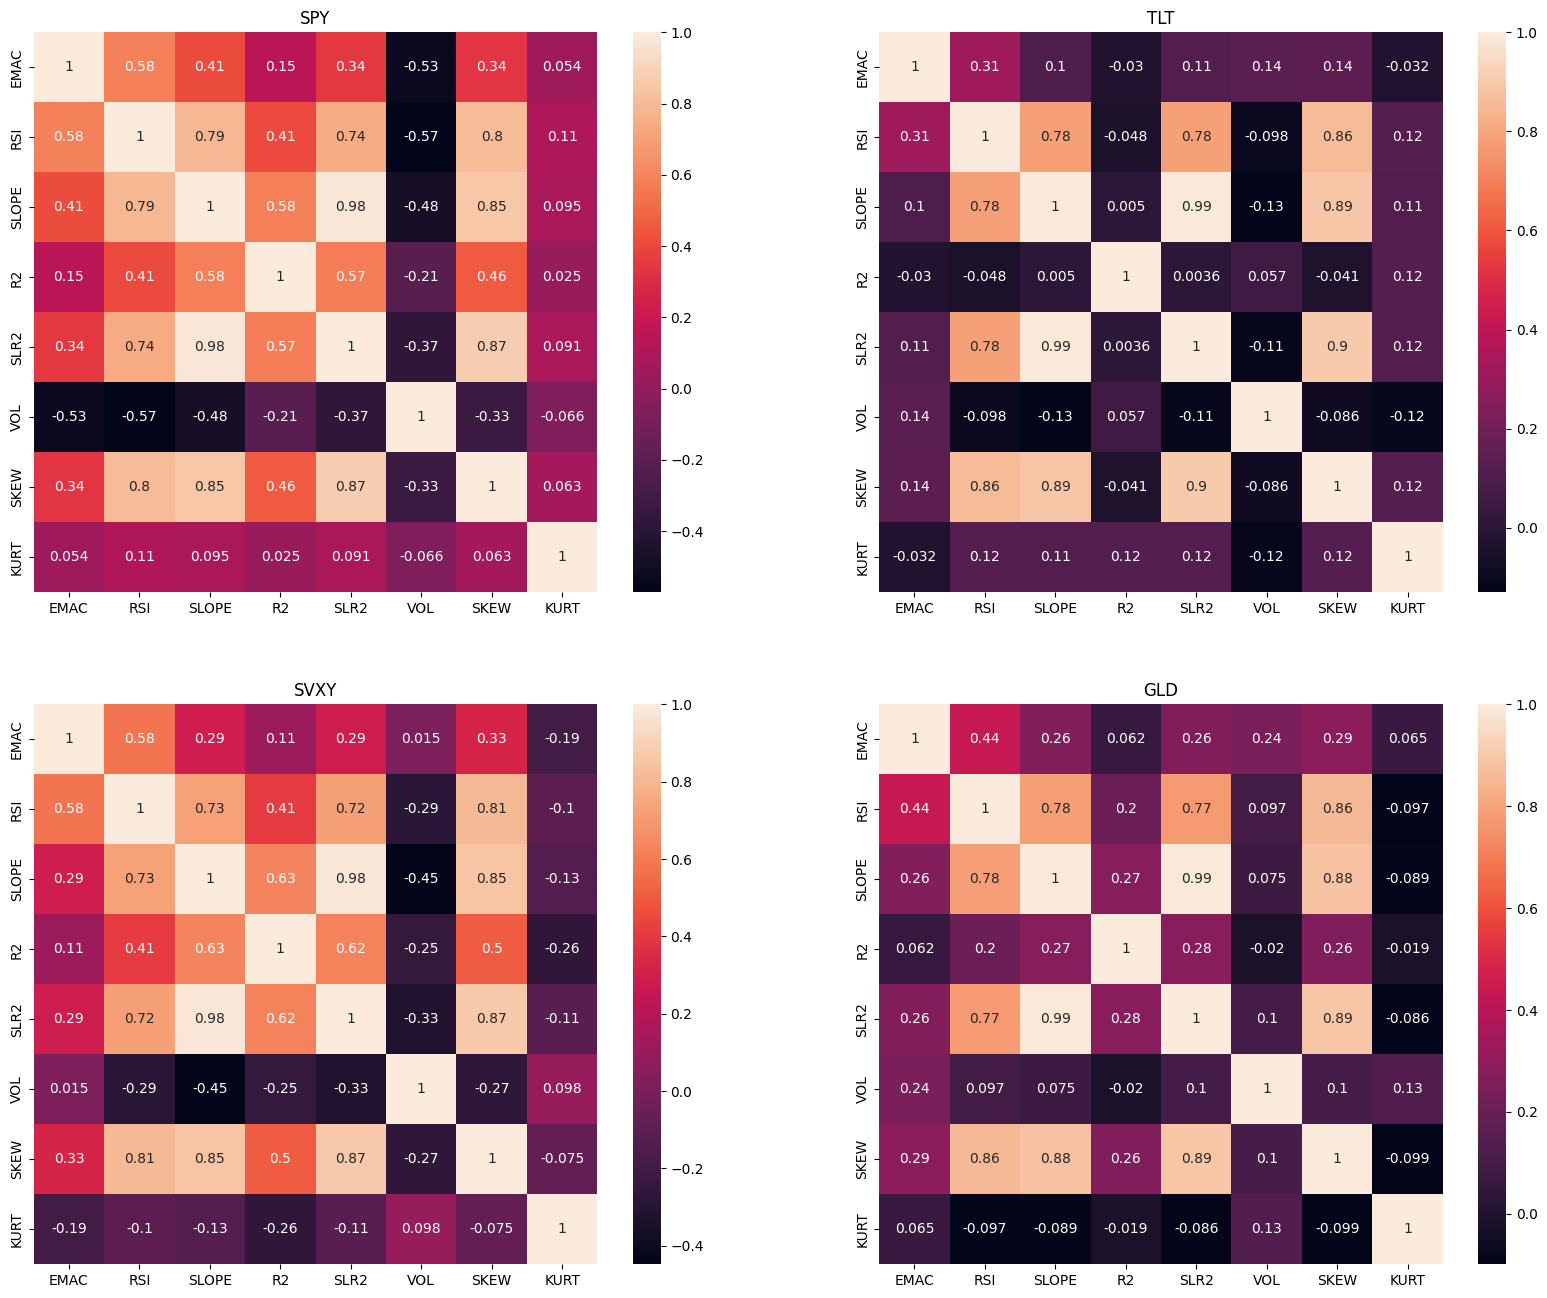

In [6]:
fig,axes = plt.subplots(2,2,figsize=(20,16))
for i,symbol in enumerate(symbols):
    ax = axes[i//2,i%2]
    ax.set_title(symbol)

    feat = all_feat[symbol]
    corr = feat.corr(method='spearman')
    print(f'{symbol} avg corr:')
    print(np.around(corr.mean(),2).to_dict())
    
    sns.heatmap(corr, annot=True, ax=ax)

# Triple-barrier Label
### Use upper, lower, and time bounds to determine whether a trend is established

1. Upper bound is defined as a positive number times volatility. When the cumulative return touched upper bound, it is considered an uptrend.

2. Lower bound is defined as a negative number times volatility. When the cumulative return touched lower bound, it is considered a downtrend.

3. Time bound is defined as a fixed holding horizon. When the holding days touched time bound, it is considered no trend within the period

$Label = \left\{
  \begin{array}{ c l }
    +1 & \quad \textrm{if cumulative return >= upper bound} \\
    -1 & \quad \textrm{if cumulative return <= lower bound} \\
    0 & \quad \textrm{if holding days >= time bound and none of vertical bounds are touched}
  \end{array}
\right.$


### Rolling approach

In [77]:
def get_label(logprc,window):
  logret = logprc.diff().shift(-1)
  vol = logret.rolling(60).std()

  tp = window ** 0.5
  sl = window ** 0.5
  hd = window

  #print(tp , sl , hd)
  label = []

  for i,ret in logret.items():
    up_bar = vol.loc[i] * tp
    low_bar = vol.loc[i] * -sl
    time_bar = hd

    future_ret = logret.loc[i:]
    cum_ret = ret
    cum_day = 1
    while True:
      if cum_ret >= up_bar:
        label.append(1)
        break
      elif cum_ret <= low_bar:
        label.append(-1)
        break
      elif cum_day >= time_bar or cum_day >= future_ret.shape[0]:
        label.append(0)
        break

      ret = future_ret.iloc[cum_day]
      cum_day += 1
      cum_ret += ret

  label = pd.Series(label , index=logret.index , name='LABEL')
  return label

### Vectorized approach

In [66]:
def get_label(logprc,window):
    logret = logprc.diff().shift(-1)
    vol = logprc.diff().rolling(60).std()

    tp = window ** 0.5
    sl = window ** 0.5
    hd = window

    time_bar = hd
    up_bar = (tp * vol).iloc[:-time_bar] # drop last n days as the labelling is forward looking
    low_bar = (-sl * vol).iloc[:-time_bar] # drop last n days as the labelling is forward looking

    # vectorize approach to run rolling Labelling
    # create rolling datasets for each day
    rolling = sliding_window_view(logret, window_shape = time_bar)
    cumret = rolling.cumsum(axis=1)[:-1]
    max_cumret = cumret.max(axis=1)
    min_cumret = cumret.min(axis=1)

    is_up = np.where(max_cumret >= up_bar, 1, 0)
    is_low = np.where(min_cumret <= low_bar, -1, 0)
    label = pd.Series(is_up + is_low, index=up_bar.index, name='LABEL')
    return label

###

In [78]:
all_label = dict()
for symbol in symbols:
  data = all_data[symbol]
  label = get_label(data,window=lookback)
  all_label[symbol] = label

### Visualize the labelling method (sanity check)
<font color='green'>Green</font> zone means there is an uptrend identified. <br>
<font color='red'>Red</font> zone means there is an downtrend identified. <br>
<font color='gray'>Gray</font> zone means there is no obvious trend. <br>

Green = Uptrend
Red   = Downtrend
Gray  = No trend
(Here shows the label every 60 days for visibility, but it is updated everyday)


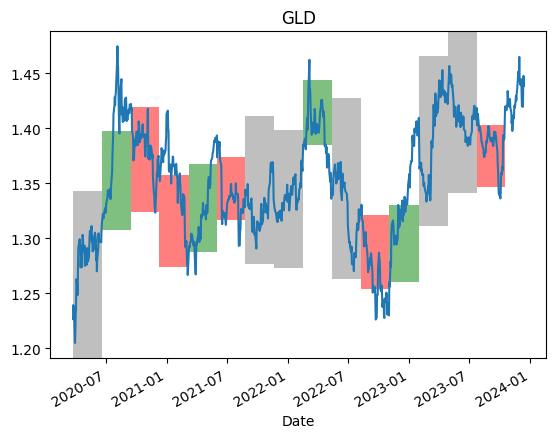

In [88]:
from matplotlib.patches import Rectangle

cum_ret = data.diff().shift(-1).cumsum()
vol = data.diff().rolling(60).std()

up_bar = 60**0.5 * vol
low_bar = 60**0.5 * vol
time_bar = 60

period = cum_ret.index[-1000:-time_bar]
dates = cum_ret.loc[period].index

sub_label = label.loc[period][::time_bar]
sub_cum_ret = cum_ret.loc[period]

ax = sub_cum_ret.plot(title=symbol)

print('Green = Uptrend')
print('Red   = Downtrend')
print('Gray  = No trend')
print(f'(Here shows the label every {time_bar} days for visibility, but it is updated everyday)')

for i,lab in enumerate(sub_label):
  if i+1 >= len(sub_label): break

  if lab == 1:
    w = sub_label.index[i+1] - sub_label.index[i]
    h = up_bar.loc[sub_label.index[i]]
    x = sub_label.index[i]
    y = sub_cum_ret[sub_label.index[i]]

    rect = Rectangle((x,y),w,h,
                     facecolor='g',alpha=0.5)
    ax.add_patch(rect)
  elif lab == -1:
    w = sub_label.index[i+1] - sub_label.index[i]
    h = up_bar.loc[sub_label.index[i]]
    x = sub_label.index[i]
    y = sub_cum_ret[sub_label.index[i]] - h

    rect = Rectangle((x,y),w,h,
                     facecolor='r',alpha=0.5)
    ax.add_patch(rect)
  elif lab == 0:
    w = sub_label.index[i+1] - sub_label.index[i]
    h = up_bar.loc[sub_label.index[i]] * 2
    x = sub_label.index[i]
    y = sub_cum_ret[sub_label.index[i]] - h/2

    rect = Rectangle((x,y),w,h,
                     facecolor='gray',alpha=0.5)
    ax.add_patch(rect)

# Concat the features and labels into one dataframe

In [94]:
all_dataset = dict()
for symbol in symbols:
    label = all_label[symbol]
    feat = all_feat[symbol]
    dataset = pd.concat([label, feat], axis=1)
    all_dataset[symbol] = dataset

# Random Forest Prediction

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression,ElasticNet

In [63]:
train_size = 1000
step = 20

all_rf_pred = dict()
all_rf_prob = dict()
#big_dataset = pd.concat(all_dataset.values(),axis=0)

for symbol in symbols:
  print(symbol)
  rf_pred_list = []
  rf_prob_list = []

  dataset = all_dataset[symbol]
  for start in range(train_size , len(dataset) , step):
    train_set = dataset.iloc[start - train_size : start]
    #train_set = dataset.iloc[ : start].loc[train_set.index]
    #big_train_set = big_dataset.loc[train_set.index]
    test_set = dataset.iloc[start : start + step]

    #big_train_y , big_train_x = big_train_set['LABEL'] , big_train_set.drop(columns='LABEL')
    train_y , train_x = train_set['LABEL'] , train_set.drop(columns='LABEL')
    test_x = test_set.drop(columns='LABEL')

    #print(f'[{test_x.index[0].date()}]' , end=' ')
    #if start%100 == 0: print()
    #sys.stdout.flush()

    rf = RandomForestClassifier(random_state=300300,
                                n_estimators=500,
                                max_depth=3)
    rf.fit(X=train_x , y=train_y)
    #rf.fit(X=big_train_x , y=big_train_y)
    rf_pred_list.append(pd.Series(rf.predict(X=test_x) , index=test_x.index))
    rf_prob_list.append(pd.DataFrame(rf.predict_proba(X=test_x) , index=test_x.index))

  rf_pred = pd.concat(rf_pred_list)
  rf_prob = pd.concat(rf_prob_list)
  all_rf_pred[symbol] = rf_pred
  all_rf_prob[symbol] = rf_prob

AUDUSD=X


In [19]:
def get_pos(pred,prob):
  l = np.where(pred == 1 , 1 * prob.iloc[:,2] , 0)
  s = np.where(pred == -1 , -1 * prob.iloc[:,0] , 0)
  pos = pd.Series(l + s , index=pred.index)
  return pos

In [22]:
def scale_vol(pnl):
  vol = pnl.std()
  scalar = .20 / 16 / vol
  scaled_pnl = pnl * scalar
  return scaled_pnl

In [21]:
probpos = get_pos(all_rf_pred['AUDUSD=X'],all_rf_prob['AUDUSD=X'])

In [ ]:
def get_pnl(pos,prob,logret,window=None,tp=None,sl=None,hd=None):
  #logret = logprc.diff().shift(-1)
  vol = logret.rolling(60).std()

  if tp is None or sl is None or hd is None:
    tp = window ** 0.5
    sl = window ** 0.5
    hd = window

  print(tp , sl , hd)
  pnl = []
  in_pos = False
  
  for i,p in pos.items():
    ret = logret.loc[i]
    if not in_pos and p!=0 and prob.loc[i,p+1]>=0.5:
      up_bar = vol.loc[i] * tp
      low_bar = vol.loc[i] * -sl
      horzn_bar = hd

      cum_ret = p * ret
      cum_day = 1
      pnl.append(p * ret)
    elif in_pos:
      cum_ret += p * ret
      cum_day += 1
      pnl.append(p * ret)
      
      if cum_ret >= up_bar or cum_ret <= low_bar or cum_day >= horzn_bar or prob.loc[i,p+1]<0.5:
        in_pos = False
    else:
      pnl.append(0)

  pnl = pd.Series(pnl , index=pos.index , name='LABEL')
  return pnl

In [ ]:
all_rf_pred['AUDUSD=X'] 

Date
2010-05-18    1
2010-05-19    1
2010-05-20    1
2010-05-21    1
2010-05-24    1
             ..
2024-03-08    1
2024-03-11    1
2024-03-12    1
2024-03-13    1
2024-03-14    1
Length: 3602, dtype: int64

2 2 20


<Axes: xlabel='Date'>

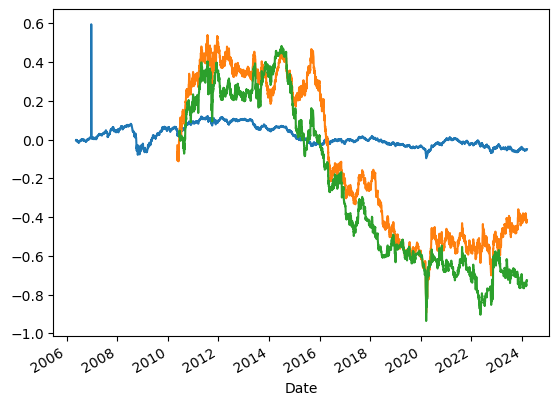

In [62]:
logret = all_data['AUDUSD=X'].diff().shift(-1)
pnl = get_pnl(all_rf_pred['AUDUSD=X'] , all_rf_prob['AUDUSD=X'] , logret , tp=2 , sl=2 , hd=20)
prob_pnl = probpos.rolling(20).mean() * logret

scale_vol(logret).cumsum().plot()
scale_vol(pnl).cumsum().plot()
scale_vol(prob_pnl).cumsum().plot()

In [ ]:
with open('all_rf_pred.pickle', 'wb') as handle:
    pickle.dump(all_rf_pred, handle, protocol=pickle.HIGHEST_PROTOCOL)
#!cp all_rf_pred.pickle "drive/My Drive/"

with open('all_rf_prob.pickle', 'wb') as handle:
    pickle.dump(all_rf_prob, handle, protocol=pickle.HIGHEST_PROTOCOL)
#!cp all_rf_prob.pickle "drive/My Drive/"

In [ ]:
with open('all_rf_pred.pickle', 'rb') as handle:
    all_rf_pred = pickle.load(handle)

with open('all_rf_prob.pickle', 'rb') as handle:
    all_rf_prob = pickle.load(handle)

In [ ]:
all_rf_pred

{}

Elapsed time to compute the importances: 20.575 seconds


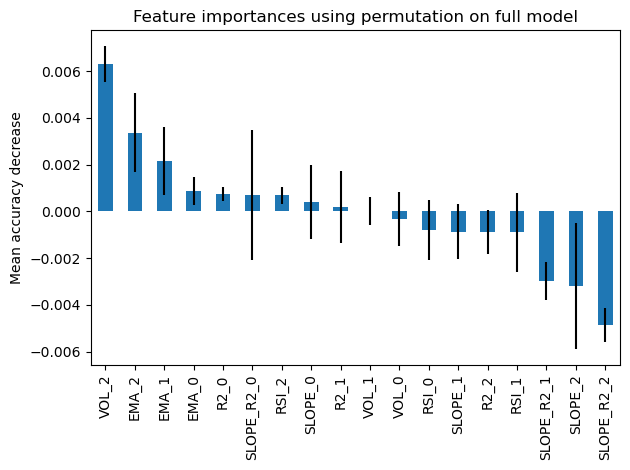

In [25]:
from sklearn.inspection import permutation_importance

start_time = time.time()
feature_names = test_x.columns
result = permutation_importance(
    rf, big_train_x, big_train_y, n_repeats=10, random_state=300300, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
mac_pred = data.ewm(20).mean() - data.ewm(80).mean()

In [ ]:
thr = 0.3
mac_pos = pd.Series(np.where(mac_pred > 0 , 1 , -1) , index=mac_pred.index)
rf_pos = rf_pred.copy().rolling(20).mean()

In [ ]:
logret = data.diff().shift(-1)

mac_pnl = mac_pos * logret
rf_pnl = rf_pos * logret

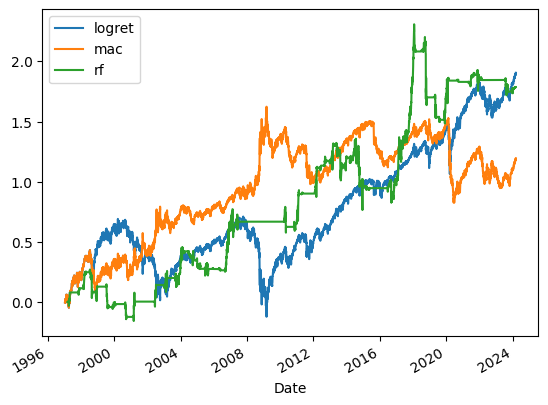

In [ ]:
period = data.index[1000:]

logret.loc[period].cumsum().plot()
mac_pnl.loc[period].cumsum().plot()
(rf_pnl.loc[period]*7).cumsum().plot()

plt.legend(['logret','mac','rf'])

In [ ]:
e = Evaluator(rf_pnl*7)
e.get_summary()

nan 0.03215926493108729


,Value,Sample size,P-value
CAGR,NaN,7836.0000,NaN
Mean,0.0662,7836.0000,NaN
Vol,0.2145,7836.0000,NaN
SR,0.3089,7836.0000,0.0000
CAPM Alpha,0.1774,2419.0000,0.1261
Carhart Alpha,0.1825,2419.0000,0.1175
Beta,-0.1306,2419.0000,0.0136
Skew,-1.9325,7836.0000,NaN
Skew (M),-0.3640,375.0000,NaN
Kurt,38.4076,7836.0000,NaN
